# Analysis of optogenetic activation experiments with short light pulses
## Comparison across experimental groups

In [1]:
from scipy.io import loadmat
from csv import reader
import numpy as np
from scipy import sparse as sps
from sys import path

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import gridspec
import matplotlib.colors as colors

import os
from glob import glob
from os.path import isfile, sep

import seaborn as sns

path.insert(1, '/Users/hannah/Dropbox/code/flyFreeWalking/')
from importCtraxData import importCtraxData

path.insert(1, '/Users/hannah/Dropbox/code/optogeneticsWalkingArena/')
from freeWalkingOptoPlotting import plotSparseMatrix, plotPosInRange

%matplotlib inline

# Note: Additional functions are defined at the end of this script. 
# Corresponding cells need to be evaluated before running the ananlysis for the first time

/Users/hannah/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
basedDir = '/Volumes/jayaramanlab/Hannah/Projects/OptoFreeWalking/1_Data/RewardTest_Laura/fullFieldPulse/'
expDir = 'SS31333-noBal_x_20xCsChrimsonWTB_female_RetWuerzburg/200ms/'
rootDir = basedDir + expDir
expGroup = '_'.join(expDir.split('/')[0:-1])

stimTms = 200
pauseTms = 15 *1000

expList = [filepath.split(sep)[-1] for filepath in glob(rootDir + sep + '*.ufmf')]
sorted(expList)

['SS31333-noBal_x_20xCsChrimsonWTB_10LED_0-2s_RetWuerzburg_female_20h_rep1_2017_06_08_18_03_48_v001.ufmf',
 'SS31333-noBal_x_20xCsChrimsonWTB_10LED_0-2s_RetWuerzburg_female_20h_rep2_2017_06_08_18_09_37_v001.ufmf']

In [3]:
fileNameParts = expGroup.split('_')

genotype = '_'.join(fileNameParts[0:3])
protocolName = '_'.join(fileNameParts[4:6])

fps = 20 # Video sampling rate

print(genotype)
print(protocolName)

SS31333-noBal_x_20xCsChrimsonWTB
RetWuerzburg_200ms


In [4]:
starvation = [movie.split('_')[7] for movie in expList]
starveGroup = list(set(starvation))

### Setup up directories for plots generated during the analysis

In [5]:
analysisDir = '/'.join([rootDir, 'analysis'])

try:
    os.mkdir(analysisDir)
except OSError:
    print('Analysis folder already exists')

Analysis folder already exists


In [6]:
for st in starveGroup:
    plotSaveDir = '/'.join([analysisDir, st])

    try:
        os.mkdir(plotSaveDir)
    except OSError:
        print('Starvation folder already exists')

Starvation folder already exists


### Select starvation group

In [7]:
starveG = starveGroup[0]
print(starveG)

20h


#### Read pulse start frames from file

In [37]:
expListFile = rootDir + 'firstFrames.csv'
stimPulseFile = rootDir + 'stimFrames.csv'

print('Reading in stimulation start frame list from ' + expListFile)

# load file specifying data to be analysed
fileList = open(expListFile, 'r')
csv_fileList = reader(fileList)

# get header
header = fileList.readline().split(',')

fileNames = []
startFrames = []
stimFrames = []

for i, line in enumerate(csv_fileList):
    if(starveG in line[1]):
        fileNames.append(line[1])
        startFrames.append(line[2])
        
        csv_pulse = reader(open(stimPulseFile))
        for k, line in enumerate(csv_pulse):
            if k == i:
                stimFrames.append(line)
                continue

Reading in stimulation start frame list from /Volumes/jayaramanlab/Hannah/Projects/OptoFreeWalking/1_Data/RewardTest_Laura/fullFieldPulse/SS31333-noBal_x_20xCsChrimsonWTB_female_RetWuerzburg/200ms/firstFrames.csv


In [38]:
print(stimFrames[0])
print(startFrames)
print(fileNames)

['174', '479', '784', '1088', '1392', '1696', '2000', '2305', '2609', '2913', '3217', '3521', '3826', '4130', '4434']
['175', '157']
['SS31333-noBal_x_20xCsChrimsonWTB_10LED_0-2s_RetWuerzburg_female_20h_rep1_2017_06_08_18_03_48_v001', 'SS31333-noBal_x_20xCsChrimsonWTB_10LED_0-2s_RetWuerzburg_female_20h_rep2_2017_06_08_18_09_37_v001']


### Import and rearrange data

In [39]:
fileInd = 0
fileName = fileNames[fileInd]+'.mat'
startFrame = int(startFrames[fileInd])
stimFrame = stimFrames[fileInd]
print(fileName)
print(startFrame)

SS31333-noBal_x_20xCsChrimsonWTB_10LED_0-2s_RetWuerzburg_female_20h_rep1_2017_06_08_18_03_48_v001.mat
175


In [40]:
stimFrame = [int(stim) for stim in stimFrame]
stimFrame

[174,
 479,
 784,
 1088,
 1392,
 1696,
 2000,
 2305,
 2609,
 2913,
 3217,
 3521,
 3826,
 4130,
 4434]

#### Extract relevant tracking parameter

In [41]:
## TODO: Replace by importCtraxData function.... 

In [42]:
keyList = ['timestamps','x_pos','y_pos','ntargets','identity','angle'] #data columns to be extracted from ctrax file

#load matlab data and convert
indat = loadmat(rootDir + sep + fileName)

dat = [indat[k] for k in keyList]
    
# Reorganise fly position arrays into lists (sorted by frame)
numFrames = len(dat[0])
xPos = []
yPos = []
angle = []
flyID = []

pointer = 0
for t in range(numFrames):
    numFlies = dat[3][t].astype('int')[0]

    xPos.append(dat[1][pointer:pointer+numFlies])
    yPos.append(dat[2][pointer:pointer+numFlies])
    angle.append(dat[5][pointer:pointer+numFlies])
    flyID.append(dat[4][pointer:pointer+numFlies])

    pointer += numFlies
    
xPos = np.array(xPos)
yPos = np.array(yPos)
angle = np.array(angle)
flyID = np.array(flyID)
maxFlyID = max(dat[4])

In [43]:
numFrames/(fps*60)

4

#### Visualise tracking performance

/Users/hannah/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


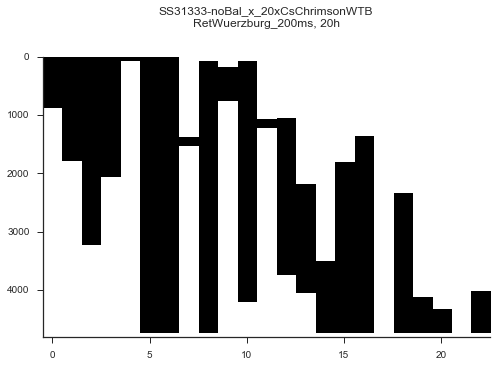

In [44]:
# Reorganise fly track fragments into matrix (frame x fly id )
flyIDperFrame = np.zeros((numFrames,maxFlyID+1))
for frame in range(numFrames):
    for idx in np.array(flyID[frame]).squeeze().astype('int'):
        flyIDperFrame[frame][idx] = 1

#visualise resluting matrix
fragmentFig = plotSparseMatrix((7,5),0.003,flyIDperFrame, genotype + '\n' + protocolName + ', '+ starveG + '\n')
fragmentFig.tight_layout()

fragmentFig.savefig(plotSaveDir + '/' + protocolName + '_'+ starveG + '_traceFragments.pdf', format = 'pdf')

### Plot tracking data
#### Visualise response of all flies to first light pulse

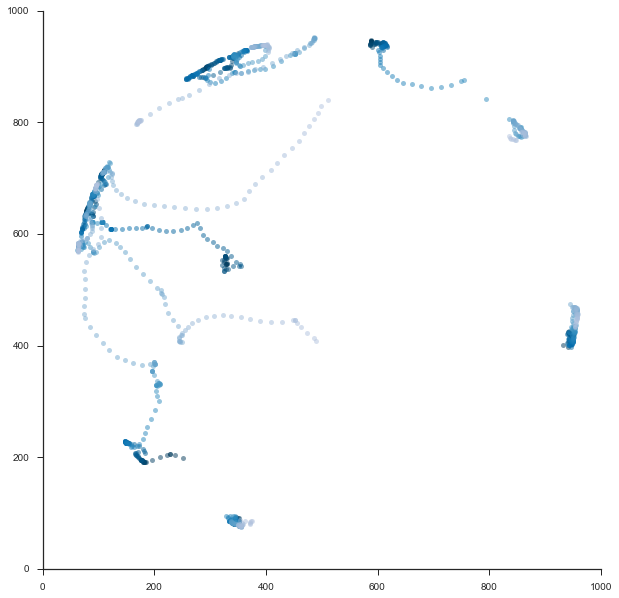

In [45]:
fig = plt.figure(figsize=(10,10))
sbplt = fig.add_subplot(111)

firstPause = range(startFrame + (stimTms/1000)*fps,startFrame + (stimTms+pauseTms)/1000 * fps,2)
plotPosInRange(sbplt,firstPause,xPos,yPos,angle,flyID,'PuBu')

#plot stimulation on top
firstStim = range(startFrame,startFrame + (stimTms/1000) * fps,2)
plotPosInRange(sbplt,firstStim,xPos,yPos,angle,flyID,'OrRd')

fig.savefig(plotSaveDir + '/' + protocolName + '_'+ starveG + '_firstTrialTraces.pdf', format = 'pdf')

### Plot per-fly walking statistics

In [48]:
numRepeat = len(stimFrame)

In [53]:
#compute translational and rotational velocity over entire experiment
#frameRange = range(startFrame,startFrame + (numRepeat*((stimTms+pauseTms)/1000)) * fps,skipFrame)
frameRange = range(0,stimFrame[-1] + pauseTms/1000 * fps)

activeFragments = np.array(np.nonzero(sum(flyIDperFrame[frameRange]))).squeeze()

transV = np.zeros((len(frameRange),len(activeFragments)))
transV_filt = np.zeros((len(frameRange),len(activeFragments)))
rotV = np.zeros((len(frameRange),len(activeFragments)))
rotV_filt = np.zeros((len(frameRange),len(activeFragments)))

for k, fly in enumerate(activeFragments):
    
    currTransV = np.zeros((len(frameRange),1))
    currRotV = np.zeros((len(frameRange),1))
    
    for ind,frame in enumerate(frameRange):
        if((not np.any(flyID[frame] == fly)) or (not np.any(flyID[frame] == fly))):
            continue;
            
        currTransV[ind] = (2.0)*np.hypot(xPos[frame][flyID[frame] == fly] - xPos[frame][flyID[frame] == fly],
                                  yPos[frame][flyID[frame] == fly] - yPos[frame][flyID[frame] == fly])
        
        currRotV[ind] = angle[frame][flyID[frame] == fly] - angle[frame][flyID[frame] == fly]
        if(currRotV[ind]>np.pi): currRotV[ind] = currRotV[ind]-2*np.pi
        if(currRotV[ind]<-np.pi): currRotV[ind] = currRotV[ind]+2*np.pi
    
    transV[:,k] = currTransV.squeeze()
    transV_filt[:,k] = np.convolve(currTransV.squeeze(), np.ones((5,))/5, mode='same')
    rotV[:,k] = currRotV.squeeze()
    rotV_filt[:,k] = np.convolve(currRotV.squeeze(), np.ones((5,))/5, mode='same')
    

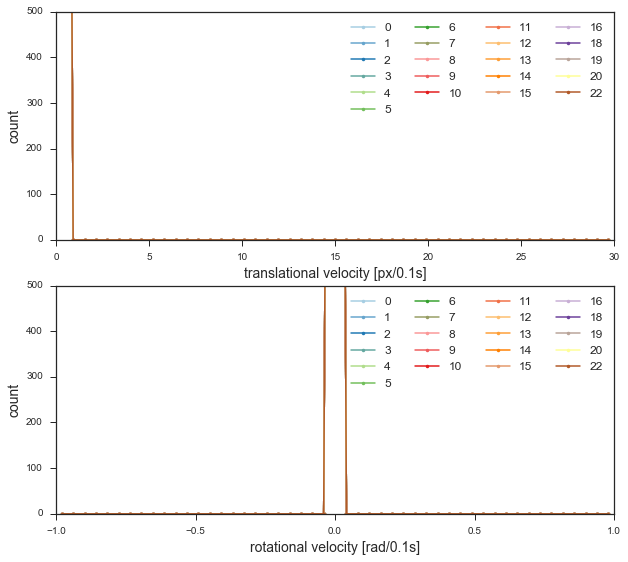

In [54]:
# Plot results
Vfig = plt.figure(figsize=(10,9))
tVplt = Vfig.add_subplot(211)
rVplt = Vfig.add_subplot(212)

vRotRange = 1

cNorm  = colors.Normalize(vmin=min(activeFragments), vmax=max(activeFragments))
FlyMap = plt.cm.ScalarMappable(norm=cNorm,cmap='Paired')

for k, fly in enumerate(activeFragments):
    flyColor = FlyMap.to_rgba(fly)
        
    histVal, binEdges = np.histogram(transV[:,k],bins=np.linspace(0,30,50))
    binLoc = binEdges[0:-1]+0.5*np.mean(np.diff(binEdges))
    tVplt.plot(binLoc,histVal,color=flyColor,marker='.',linewidth=1.5)
    
    histVal, binEdges = np.histogram(rotV[:,k],bins=np.linspace(-vRotRange,vRotRange,50))
    binLoc = binEdges[0:-1]+0.5*np.mean(np.diff(binEdges))
    rVplt.plot(binLoc,histVal,color=flyColor,marker='.',linewidth=1.5)


tVplt.set_ylim((0,500))
tVplt.set_xlim((0,30))
tVplt.set_xlabel('translational velocity [px/0.1s]',fontsize = 14)
tVplt.set_ylabel('count',fontsize = 14)
tVplt.legend(activeFragments,ncol=4,fontsize = 12)
tVplt.yaxis.set_ticks_position('left')
tVplt.xaxis.set_ticks_position('bottom')

rVplt.set_ylim((0,500))
rVplt.set_xlim((-vRotRange,vRotRange))
rVplt.set_xlabel('rotational velocity [rad/0.1s]',fontsize = 14)
rVplt.set_ylabel('count',fontsize = 14)
rVplt.legend(activeFragments,ncol=4,fontsize = 12)
rVplt.yaxis.set_ticks_position('left')
rVplt.xaxis.set_ticks_position('bottom')


Vfig.savefig(plotSaveDir + '/' + protocolName + '_'+ starveG + '_veloDistribution.pdf', format = 'pdf')

#### Trigger on light ON

In [302]:
windowPreMS = 1000
windowPostMS = 6000
stimDurationS = stimTms/1000
#Note: to be able to look at pre-stimulus window, the first trial is not regarded
trialBegin = [startFrame + (k*(pulsePeriod)/1000.0)*fps/skipFrame for k in range(numRepeat)]
trialWindowBlockPts = ((stimTms+windowPreMS+windowPostMS)/1000.0)*fps/skipFrame
trialWindowBlockT = np.linspace(-windowPreMS/1000.0,(stimTms+windowPostMS)/1000.0,trialWindowBlockPts)
plotBegin = [trialBegin[i]-windowPreMS/1000.0*fps/skipFrame for i in range(len(trialBegin))]

In [303]:
trialBegin

[80.0,
 484.79999999999995,
 889.5999999999999,
 1294.4,
 1699.1999999999998,
 2104.0,
 2508.8,
 2913.6000000000004,
 3318.3999999999996,
 3723.2,
 4128.0,
 4532.799999999999,
 4937.6,
 5342.4,
 5747.200000000001]

In [304]:
transV_nan = transV
transV_nan[transV_nan== 0] = np.nan

transV_nan_mean = np.nanmean(transV_nan, axis=1)

rotV_nan = abs(rotV)
rotV_nan[rotV_nan== 0] = np.nan

rotV_nan_mean = np.nanmean(rotV_nan, axis=1)

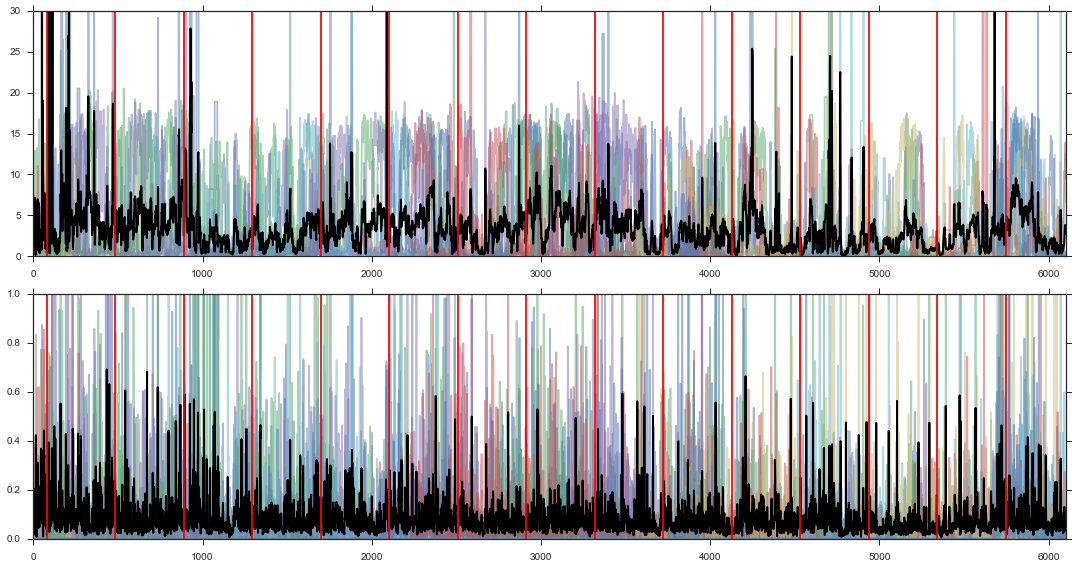

In [305]:
vTRfig = plt.figure(figsize=(15,8))

vTplt = vTRfig.add_subplot(211)
vTplt.plot(transV[:,:],alpha=0.5)
vTplt.plot(transV_nan_mean,color='black', linewidth=2)
for tb in trialBegin:
    vTplt.axvline(tb,color='red')
vTplt.set_xlim(0,6100)
vTplt.set_ylim(0,30)

vRplt = vTRfig.add_subplot(212)
vRplt.plot(abs(rotV[:,:]),alpha=0.5)
vRplt.plot(rotV_nan_mean,color='black', linewidth=2)
for tb in trialBegin:
    vRplt.axvline(tb,color='red')
vRplt.set_xlim(0,6100)
vRplt.set_ylim(0,1)

plt.tight_layout()
vTRfig.savefig(plotSaveDir + '/' + trialName + '_veloTseries.pdf', format = 'pdf')

In [306]:
transV_nan = transV_filt
transV_nan[transV_nan== 0] = np.nan

transV_nan_mean = np.nanmean(transV_nan, axis=1)

rotV_nan = abs(rotV_filt)
rotV_nan[rotV_nan== 0] = np.nan

rotV_nan_mean = np.nanmean(rotV_nan, axis=1)

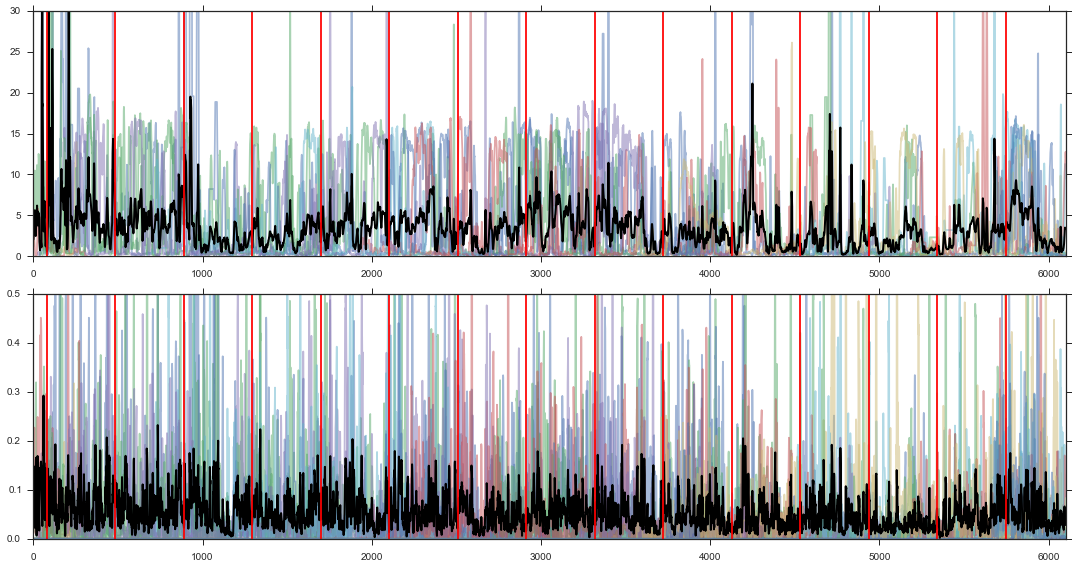

In [307]:
vTRfig = plt.figure(figsize=(15,8))

vTplt = vTRfig.add_subplot(211)
vTplt.plot(transV_filt[:,:],alpha=0.5)
vTplt.plot(transV_nan_mean,color='black', linewidth=2)
for tb in trialBegin:
    vTplt.axvline(tb,color='red')
vTplt.set_xlim(0,6100)
vTplt.set_ylim(0,30)

vRplt = vTRfig.add_subplot(212)
vRplt.plot(abs(rotV_filt[:,:]),alpha=0.5)
vRplt.plot(rotV_nan_mean,color='black', linewidth=2)
for tb in trialBegin:
    vRplt.axvline(tb,color='red')
vRplt.set_xlim(0,6100)
vRplt.set_ylim(0,0.5)

plt.tight_layout()
vTRfig.savefig(plotSaveDir + '/' + trialName + '_veloTseries_filt.pdf', format = 'pdf')

problem with trace fragment of fly25


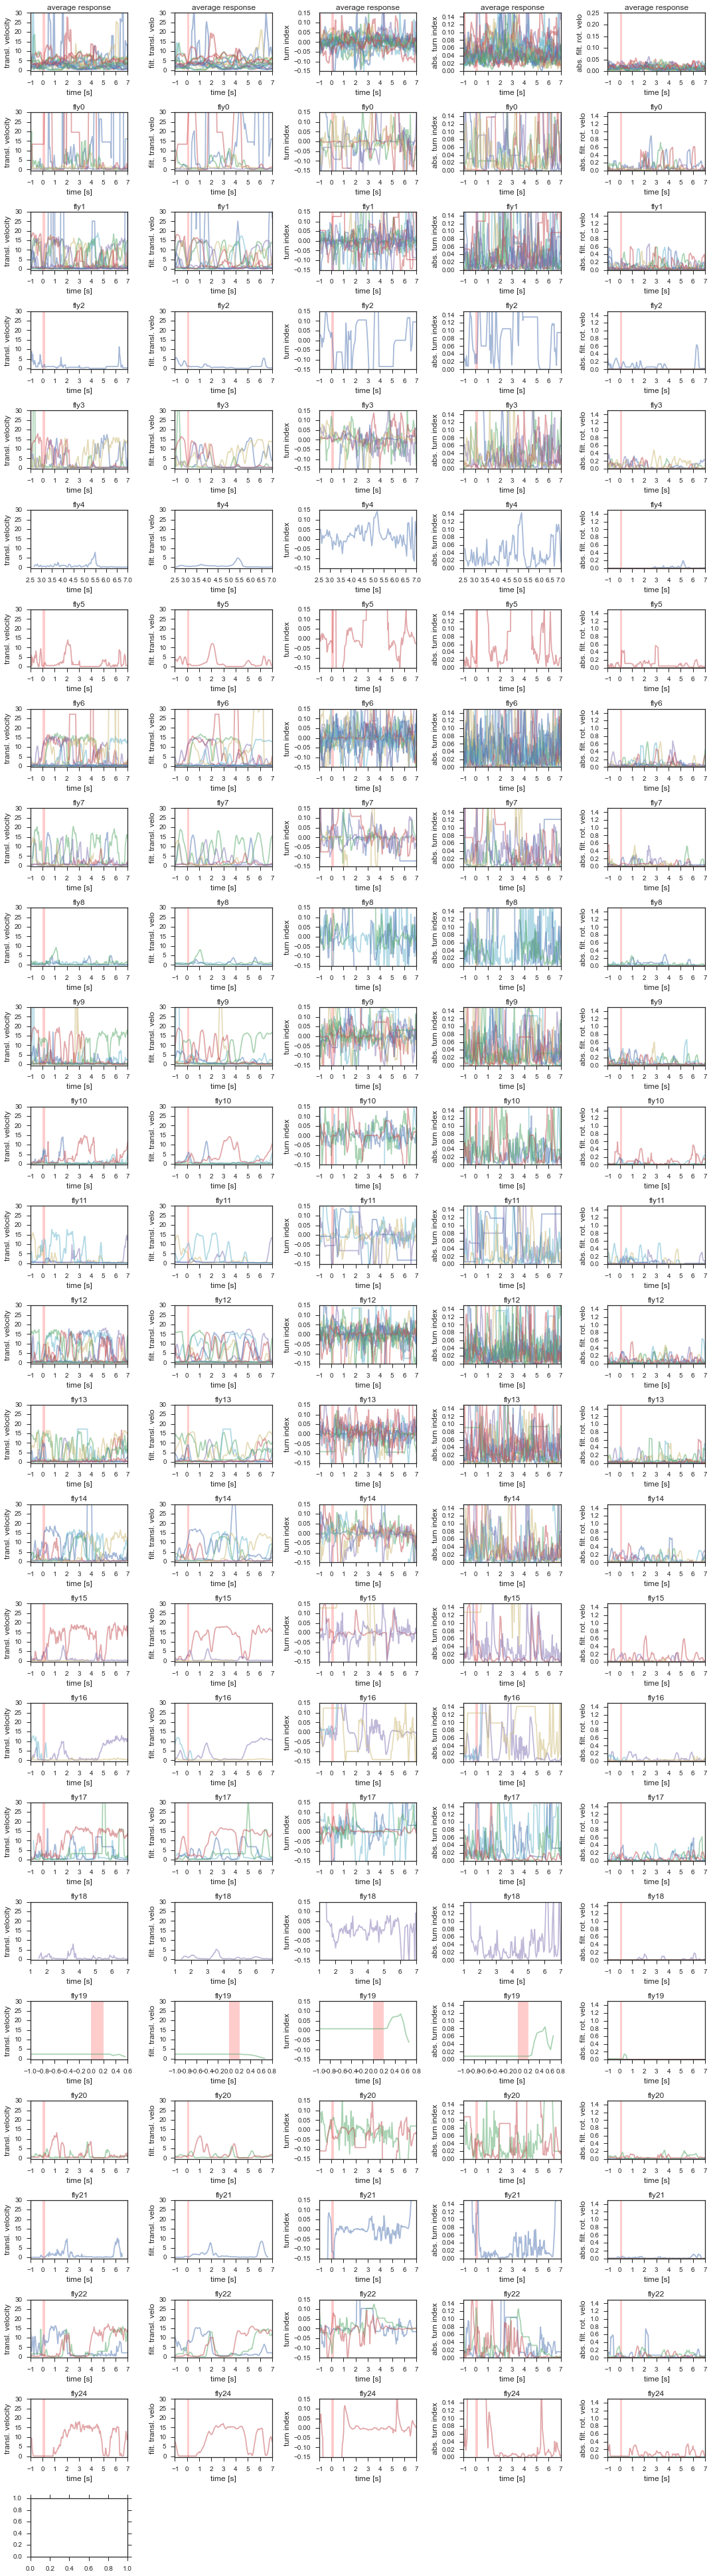

In [308]:
fig=plt.figure(figsize=(15,2*len(activeFragments)+4))

nPlot = 5

patchWidth = 0.2

vTplt = fig.add_subplot(len(activeFragments)+1,nPlot,1)
veloPerTrialAverage(transV,trialWindowBlockT,plotBegin,'transl. velocity',vTplt)
vTplt.add_patch(patches.Rectangle((0,-1), patchWidth, 50,alpha = 0.2, facecolor = 'red', edgecolor = 'none'))
vTplt.set_ylim((-0.5,30))

vTfplt = fig.add_subplot(len(activeFragments)+1,nPlot,2)
veloPerTrialAverage(transV_filt,trialWindowBlockT,plotBegin,'filt. transl. velo',vTfplt)
vTfplt.add_patch(patches.Rectangle((0,-1), patchWidth, 50,alpha = 0.2, facecolor = 'red', edgecolor = 'none'))
vTfplt.set_ylim((-0.5,30))

vRfplt = fig.add_subplot(len(activeFragments)+1,nPlot,3)
veloPerTrialAverage(rotV_filt/transV_filt,trialWindowBlockT,plotBegin,'turn index',vRfplt)
vRfplt.add_patch(patches.Rectangle((0,-5), patchWidth, 10,alpha = 0.2, facecolor = 'red', edgecolor = 'none'))
vRfplt.set_ylim((-0.15,0.15))
        
avRplt = fig.add_subplot(len(activeFragments)+1,nPlot,4)
veloPerTrialAverage(abs(rotV_filt/transV_filt),trialWindowBlockT,plotBegin,'abs. turn index',avRplt)
avRplt.add_patch(patches.Rectangle((0,-5), patchWidth, 10,alpha = 0.2, facecolor = 'red', edgecolor = 'none'))
avRplt.set_ylim((0,0.15))

aRplt = fig.add_subplot(len(activeFragments)+1,nPlot,5)
veloPerTrialAverage(abs(rotV_filt),trialWindowBlockT,plotBegin,'abs. filt. rot. velo',aRplt)
aRplt.add_patch(patches.Rectangle((0,-5), patchWidth, 10,alpha = 0.2, facecolor = 'red', edgecolor = 'none'))
aRplt.set_ylim((0,.25))

sbpltCounter = nPlot+1

for fly in activeFragments:
    
    try:
        vTplt = fig.add_subplot(len(activeFragments)+1,nPlot,sbpltCounter)
        veloPerTrial(transV,trialWindowBlockT,plotBegin,fly,'transl. velocity',vTplt)
        vTplt.add_patch(patches.Rectangle((0,-1), patchWidth, 50,alpha = 0.2, facecolor = 'red', edgecolor = 'none'))
        vTplt.set_ylim((-0.5,30))
        
        vTfplt = fig.add_subplot(len(activeFragments)+1,nPlot,sbpltCounter+1)
        veloPerTrial(transV_filt,trialWindowBlockT,plotBegin,fly,'filt. transl. velo',vTfplt)
        vTfplt.add_patch(patches.Rectangle((0,-1), patchWidth, 50,alpha = 0.2, facecolor = 'red', edgecolor = 'none'))
        vTfplt.set_ylim((-0.5,30))
        
        vRfplt = fig.add_subplot(len(activeFragments)+1,nPlot,sbpltCounter+2)
        veloPerTrial(rotV_filt/transV_filt,trialWindowBlockT,plotBegin,fly,'turn index',vRfplt)
        vRfplt.add_patch(patches.Rectangle((0,-5), patchWidth, 10,alpha = 0.2, facecolor = 'red', edgecolor = 'none'))
        vRfplt.set_ylim((-0.15,0.15))
        
        avRplt = fig.add_subplot(len(activeFragments)+1,nPlot,sbpltCounter+3)
        veloPerTrial(abs(rotV_filt/transV_filt),trialWindowBlockT,plotBegin,fly,'abs. turn index',avRplt)
        avRplt.add_patch(patches.Rectangle((0,-5), patchWidth, 10,alpha = 0.2, facecolor = 'red', edgecolor = 'none'))
        avRplt.set_ylim((0,0.15))
        
        aRplt = fig.add_subplot(len(activeFragments)+1,nPlot,sbpltCounter+4)
        veloPerTrial(abs(rotV_filt),trialWindowBlockT,plotBegin,fly,'abs. filt. rot. velo',aRplt)
        aRplt.add_patch(patches.Rectangle((0,-5), patchWidth, 10,alpha = 0.2, facecolor = 'red', edgecolor = 'none'))
        aRplt.set_ylim((0,1.5))
        
        sbpltCounter +=nPlot
        
    except:
        print('problem with trace fragment of fly' + str(fly))
        
plt.tight_layout()
fig.savefig(plotSaveDir + '/' + trialName + '_perFlySummary.pdf', format = 'pdf')

In [309]:
def veloPerFlyAverage_movementFiltered(transVelo,movingFlag,slctWindow,movingTH, velo,windowT,tBegin,fly,\
                                       ylableString,subplotHandle,colorCode):
    veloAv = np.zeros((len(trialBegin),len(windowT)))
    for i in range(len(trialBegin)):
        if movingFlag: #filter for fly walking at trial onset
            if np.nanmean(transVelo[tBegin[i]+slctWindow[0]:tBegin[i]+slctWindow[1],fly])>movingTH:
                veloAv[i,:] = velo[tBegin[i]:tBegin[i]+len(windowT),fly]
            else:
                veloAv[i,:] = np.nan*np.ones(len(windowT))
                
        else: #filter for fly standing at trial onset
            if np.nanmean(transVelo[tBegin[i]+slctWindow[0]:tBegin[i]+slctWindow[1],fly])<movingTH:
                veloAv[i,:] = velo[tBegin[i]:tBegin[i]+len(windowT),fly]
            else:
                veloAv[i,:] = np.nan*np.ones(len(windowT))
    
    veloAv = np.nanmean(veloAv,0)

    subplotHandle.plot(windowT,veloAv,alpha=0.5,color=colorCode)
    subplotHandle.set_ylabel(ylableString,fontsize=12)
    subplotHandle.set_xlabel('time [s]',fontsize=12)  
    subplotHandle.set_title('fly' + str(fly))
    subplotHandle.yaxis.set_ticks_position('left')
    subplotHandle.xaxis.set_ticks_position('bottom')

problem with trace fragment of fly25


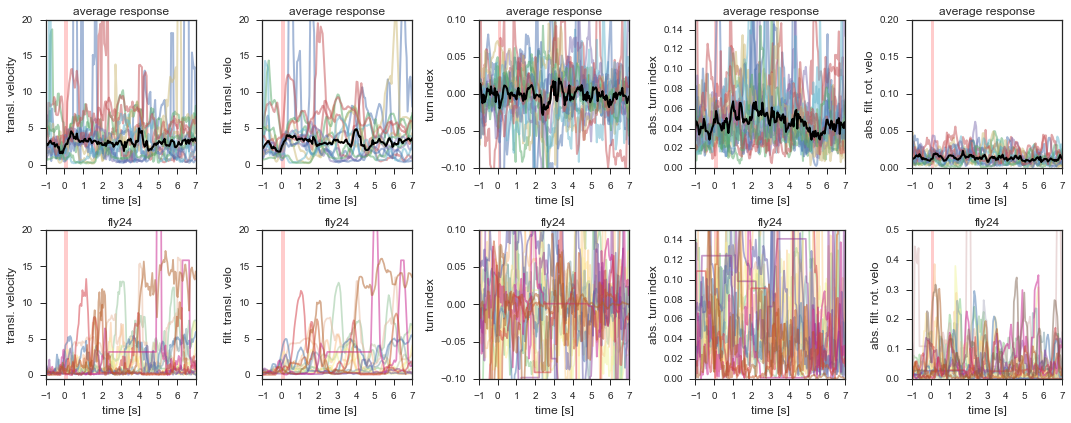

In [310]:
# Plot just per-fly trial averages

cNorm  = colors.Normalize(vmin=0, vmax=len(activeFragments))
flyCMap = plt.cm.ScalarMappable(norm=cNorm,cmap='Accent')

turnInd = rotV_filt/transV_filt
meanTransV = np.median([np.nanmean(transV[plotBegin[i]:plotBegin[i]+len(trialWindowBlockT), :], 1) for i in range(len(plotBegin))],0)
meanTransV_filt = np.median([np.nanmean(transV_filt[plotBegin[i]:plotBegin[i]+len(trialWindowBlockT), :], 1) for i in range(len(plotBegin))],0)
meanTurnInd = np.median([np.nanmean(turnInd[plotBegin[i]:plotBegin[i]+len(trialWindowBlockT), :], 1) for i in range(len(plotBegin))],0)
meanAbsTurnInd = np.median([np.nanmean(abs(turnInd[plotBegin[i]:plotBegin[i]+len(trialWindowBlockT), :]), 1) for i in range(len(plotBegin))],0)
meanRotV = np.median([np.nanmean(rotV[plotBegin[i]:plotBegin[i]+len(trialWindowBlockT), :], 1) for i in range(len(plotBegin))],0)
meanRotV_filt = np.median([np.nanmean(rotV_filt[plotBegin[i]:plotBegin[i]+len(trialWindowBlockT), :], 1) for i in range(len(plotBegin))],0)
meanAbsRotV_filt = np.median([np.nanmean(abs(rotV_filt[plotBegin[i]:plotBegin[i]+len(trialWindowBlockT), :]), 1) for i in range(len(plotBegin))],0)


#collect mean responses for later line/experiment comparison
meanRespPerLine = {
    'time': trialWindowBlockT,
    'meanTransV': meanTransV,
    'meanTransV_filt': meanTransV_filt,
    'meanTurnInd': meanTurnInd,
    'meanAbsTurnInd': meanAbsTurnInd,
    'meanRotV': meanRotV,
    'meanRotV_filt': meanRotV_filt,
    'meanAbsRotV_filt':meanAbsRotV_filt
}

#np.save(plotSaveDir + '/' + genotype + '_' + experiment + '_meanResponses', meanRespPerLine)

fig=plt.figure(figsize=(15,6))

nPlot = 5

vTplt = fig.add_subplot(2,nPlot,1)
veloPerTrialAverage(transV,trialWindowBlockT,plotBegin,'transl. velocity',vTplt)
vTplt.plot(trialWindowBlockT,meanTransV, linewidth=2, color='k')
vTplt.add_patch(patches.Rectangle((0,-1), patchWidth, 50,alpha = 0.2, facecolor = 'red', edgecolor = 'none'))
vTplt.set_ylim((-0.5,20))

vTfplt = fig.add_subplot(2,nPlot,2)
veloPerTrialAverage(transV_filt,trialWindowBlockT,plotBegin,'filt. transl. velo',vTfplt)
vTfplt.plot(trialWindowBlockT,meanTransV_filt, linewidth=2, color='k')
vTfplt.add_patch(patches.Rectangle((0,-1), patchWidth, 50,alpha = 0.2, facecolor = 'red', edgecolor = 'none'))
vTfplt.set_ylim((-0.5,20))

vRfplt = fig.add_subplot(2,nPlot,3)
veloPerTrialAverage(rotV_filt/transV_filt,trialWindowBlockT,plotBegin,'turn index',vRfplt)
vRfplt.plot(trialWindowBlockT,meanTurnInd, linewidth=2, color='k')
vRfplt.add_patch(patches.Rectangle((0,-5), patchWidth, 10,alpha = 0.2, facecolor = 'red', edgecolor = 'none'))
vRfplt.set_ylim((-0.1,0.1))
        
avRplt = fig.add_subplot(2,nPlot,4)
veloPerTrialAverage(abs(rotV_filt/transV_filt),trialWindowBlockT,plotBegin,'abs. turn index',avRplt)
avRplt.plot(trialWindowBlockT, meanAbsTurnInd, linewidth=2, color='k')
avRplt.add_patch(patches.Rectangle((0,-5), patchWidth, 10,alpha = 0.2, facecolor = 'red', edgecolor = 'none'))
avRplt.set_ylim((0,0.15))

aRplt = fig.add_subplot(2,nPlot,5)
veloPerTrialAverage(abs(rotV_filt),trialWindowBlockT,plotBegin,'abs. filt. rot. velo',aRplt)
aRplt.plot(trialWindowBlockT, meanAbsRotV_filt, linewidth=2, color='k')
aRplt.add_patch(patches.Rectangle((0,-5), patchWidth, 10,alpha = 0.2, facecolor = 'red', edgecolor = 'none'))
aRplt.set_ylim((0,0.2))

sbpltCounter = nPlot+1

movingFlag = False
slctWindow = (0,10)
movingTH = 1.0

for fly in activeFragments:
    
    try: 
        vTplt = fig.add_subplot(2,nPlot,sbpltCounter)
        veloPerFlyAverage_movementFiltered(transV,movingFlag,slctWindow,movingTH,\
                                           transV,trialWindowBlockT,plotBegin,fly,'transl. velocity',vTplt,flyCMap.to_rgba(fly))
        vTplt.set_ylim((-0.5,20))

        vTfplt = fig.add_subplot(2,nPlot,sbpltCounter+1)
        veloPerFlyAverage_movementFiltered(transV,movingFlag,slctWindow,movingTH,\
                                           transV_filt,trialWindowBlockT,plotBegin,fly,'filt. transl. velo',vTfplt,flyCMap.to_rgba(fly))
        vTfplt.set_ylim((-0.5,20))

        vRfplt = fig.add_subplot(2,nPlot,sbpltCounter+2)
        veloPerFlyAverage_movementFiltered(transV,movingFlag,slctWindow,movingTH,\
                                           rotV_filt/transV_filt,trialWindowBlockT,plotBegin,fly,'turn index',vRfplt,flyCMap.to_rgba(fly))
        vRfplt.set_ylim((-0.1,0.1))

        avRplt = fig.add_subplot(2,nPlot,sbpltCounter+3)
        veloPerFlyAverage_movementFiltered(transV,movingFlag,slctWindow,movingTH,\
                                           abs(rotV_filt/transV_filt),trialWindowBlockT,plotBegin,fly,'abs. turn index',avRplt,flyCMap.to_rgba(fly))
        avRplt.set_ylim((0,0.15))

        aRplt = fig.add_subplot(2,nPlot,sbpltCounter+4)
        veloPerFlyAverage_movementFiltered(transV,movingFlag,slctWindow,movingTH,\
                                           abs(rotV_filt),trialWindowBlockT,trialBegin,fly,'abs. filt. rot. velo',aRplt,flyCMap.to_rgba(fly))
        aRplt.set_ylim((0,0.5))

    except:
        print('problem with trace fragment of fly' + str(fly))
        
vTplt.add_patch(patches.Rectangle((0,-1), patchWidth, 50,alpha = 0.2, facecolor = 'red', edgecolor = 'none'))
vTfplt.add_patch(patches.Rectangle((0,-1), patchWidth, 50,alpha = 0.2, facecolor = 'red', edgecolor = 'none'))
vRfplt.add_patch(patches.Rectangle((0,-5), patchWidth, 10,alpha = 0.2, facecolor = 'red', edgecolor = 'none'))
avRplt.add_patch(patches.Rectangle((0,-5), patchWidth, 10,alpha = 0.2, facecolor = 'red', edgecolor = 'none'))
aRplt.add_patch(patches.Rectangle((0,-5), patchWidth, 10,alpha = 0.2, facecolor = 'red', edgecolor = 'none'))


plt.tight_layout()
fig.savefig(plotSaveDir + '/' + trialName + '_summary.pdf', format = 'pdf')

### Effect of stimulation

problem with trace fragment of fly46


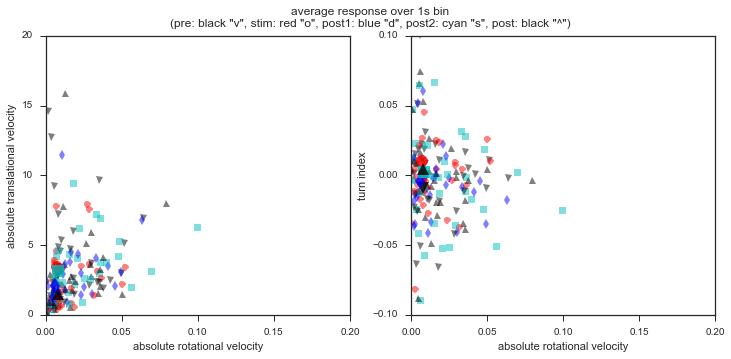

In [264]:
cNorm  = colors.Normalize(vmin=0, vmax=len(activeFragments))
flyCMap = plt.cm.ScalarMappable(norm=cNorm,cmap='Accent')

# For 1s long stim
respFig = plt.figure(figsize=(12,5))
respPlt1 = respFig.add_subplot(121)
respPlt2 = respFig.add_subplot(122)

perFlyAvVT = np.nan*np.ones((len(activeFragments),5))
perFlyAvVR = np.nan*np.ones((len(activeFragments),5))
perFlyAvTI = np.nan*np.ones((len(activeFragments),5))

for fly in activeFragments:
    blockSize = 10
    numBlocks = 5
    markerList = ['v','o','d','s','^']
    colorList = ['k','r','b','c','k']
    try:
        for block in range(numBlocks):
            perFlyVT = np.zeros((numBlocks, blockSize, len(plotBegin)))
            perFlyVR = np.zeros((numBlocks, blockSize, len(plotBegin)))
            perFlyTI = np.zeros((numBlocks, blockSize, len(plotBegin)))
            for i in range(len(plotBegin)):
                perFlyVT[block,:,i] = transV_filt[plotBegin[i]+block*blockSize:plotBegin[i]+(block+1)*blockSize,fly]
                perFlyVR[block,:,i] = abs(rotV_filt[plotBegin[i]+block*blockSize:plotBegin[i]+(block+1)*blockSize,fly])
                perFlyTI[block,:,i] = rotV_filt[plotBegin[i]+block*blockSize:plotBegin[i]+(block+1)*blockSize,fly]/transV_filt[plotBegin[i]+block*blockSize:plotBegin[i]+(block+1)*blockSize,fly]

            respPlt1.plot(np.mean(np.nanmean(perFlyVR[block,:,:],1)),np.mean(np.nanmean(perFlyVT[block,:,:],1)),
                         marker=markerList[block],linestyle='',color=colorList[block],alpha=0.5)
            respPlt2.plot(np.mean(np.nanmean(perFlyVR[block,:,:],1)),np.mean(np.nanmean(perFlyTI[block,:,:],1)),
                         marker=markerList[block],linestyle='',color=colorList[block],alpha=0.5)
            perFlyAvVT[fly,block] = np.mean(np.nanmean(perFlyVT[block,:,:],0))
            perFlyAvVR[fly,block] = np.mean(np.nanmean(perFlyVR[block,:,:],0))
            perFlyAvTI[fly,block] = np.mean(np.nanmean(perFlyTI[block,:,:],0))

    except:
        print('problem with trace fragment of fly' + str(fly))

for block in range(numBlocks):
    respPlt1.plot(np.nanmedian(perFlyAvVR[:,block]),np.nanmedian(perFlyAvVT[:,block]),
                 color=colorList[block],marker=markerList[block],markersize=12,linestyle='',alpha=.8)
    respPlt2.plot(np.nanmedian(perFlyAvVR[:,block]),np.nanmedian(perFlyAvTI[:,block]),
                  color=colorList[block],marker=markerList[block],markersize=12,linestyle='',alpha=.8)

respPlt1.set_xlabel('absolute rotational velocity')
respPlt1.set_ylabel('absolute translational velocity')
respPlt1.yaxis.set_ticks_position('left')
respPlt1.xaxis.set_ticks_position('bottom')
respPlt1.set_xlim(0,0.2)
respPlt1.set_ylim(0,20)
respPlt2.set_ylabel('turn index')
respPlt2.set_xlabel('absolute rotational velocity')
respPlt2.yaxis.set_ticks_position('left')
respPlt2.xaxis.set_ticks_position('bottom')
respPlt2.set_ylim(-0.1,0.1)
respPlt2.set_xlim(0,0.2)

respFig.suptitle('average response over 1s bin\n'+
                 '(pre: black "v", stim: red "o", post1: blue "d", post2: cyan "s", post: black "^")',
                fontsize=12)
#respFig.tight_layout()
#respFig.savefig(plotSaveDir + '/' + genotype + '_' + experiment + '_binnedEffect.pdf', format = 'pdf')

#### Compute differences between the average responses for each fly and the average response

### Plot distribution and trajectories of responding flies

IndexError: index 6300 is out of bounds for axis 0 with size 6300

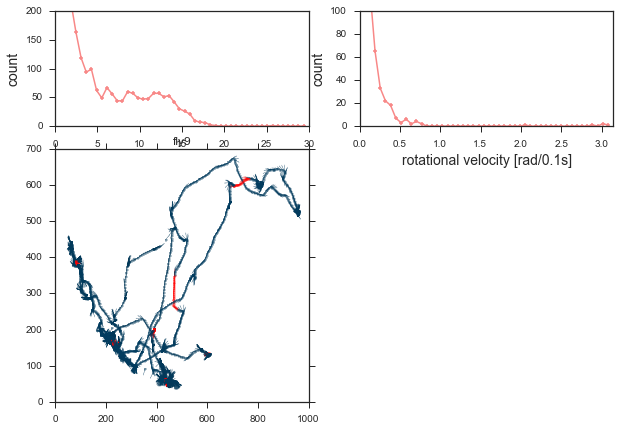

In [306]:
fly = 9
numRepeat_fly = 6


fullExperiment = range(startFrame,startFrame + numRepeat_fly*(pulsePeriod),skipFrame)
stimCodeFrames = stimCode[range(0,len(stimCode),skipFrame)]
trialCodeFrames = trialCode[range(0,len(trialCode),skipFrame)]

fig=plt.figure(figsize=(10,7))

tVplt = fig.add_subplot(3,2,1)
plotVeloHistogram(transV,fly,np.linspace(0,30,50),tVplt,'translational velocity [px/0.1s]',FlyMap.to_rgba(fly))
tVplt.set_ylim((0,200))
tVplt.set_xlim((0,30))


rVplt = fig.add_subplot(3,2,2)
plotVeloHistogram(rotV,fly,np.linspace(0,np.pi,50),rVplt,'rotational velocity [px/0.1s]',FlyMap.to_rgba(fly))
rVplt.set_ylim((0,100))
rVplt.set_xlim((0,np.pi))
rVplt.set_xlabel('rotational velocity [rad/0.1s]',fontsize = 14)


posPlt = fig.add_subplot(3,2,(3,5))
posPlt.set_title('fly' + str(fly))
plotPosInRange_singleFly_colorStim(posPlt,fullExperiment,stimCodeFrames,xPos,yPos,angle,fly,'PuBu')


posPlt = fig.add_subplot(3,2,(4,6))
posPlt.set_title('fly' + str(fly))
plotPosInRange_singleFly_colorTrial(posPlt,fullExperiment,stimCodeFrames,trialCodeFrames,
                                    len(trialCodeFrames)/numRepeat,xPos,yPos,angle,fly,'nipy_spectral')

plt.tight_layout()
#fig.savefig(plotSaveDir + '/' + genotype + '_' + experiment + '_fly' + str(fly) + '.pdf', format = 'pdf')

IndexError: list index out of range

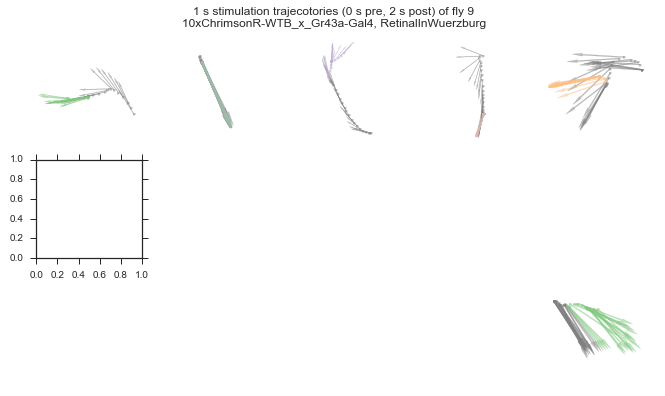

In [308]:
trialBegin_traces = [(startFrame + k*(pulsePeriod)/1000)*fps for k in range(numRepeat_fly)]
windowSize = 2
skipFrame = 1
stimFrames = stimTms/1000 * fps
preStimFrames = (windowSize-2)*fps
postStimFrames = windowSize*fps
#colorRange = ['grey','orangered','darkred']

fig = plt.figure(figsize=(11,6))
fig.suptitle(str(stimTms/1000)+' s stimulation trajecotories ('+str(windowSize-2)+' s pre, '+str(windowSize)+' s post) of fly '
             +str(fly)+'\n' + genotype+', '+protocolName,  fontsize = 12)
plotPosInRange_singleFly_separateTrials(fig,trialBegin_traces,numRepeat,stimFrames,postStimFrames,skipFrame,
                                         xPos,yPos,angle,fly,'Accent')
#plotPosInRange_singleFly_separateTrials(fig,trialBegin_traces,numRepeat,preStimFrames,stimFrames,postStimFrames,skipFrame,
#                                         xPos,yPos,angle,fly,colorRange)

#fig.savefig(plotSaveDir + '/' + genotype + '_' + experiment + '_perTrialfly' + str(fly) + '.pdf', format = 'pdf')

In [ ]:
fig = plt.figure(figsize=(11,6))
fig.suptitle(str(stimTms/1000)+' s stimulation trajecotories ('+str(windowSize-2)+' s pre, '+str(windowSize)+' s post) of fly '
             +str(fly)+'\n' + genotype+', '+protocolName,  fontsize = 12)
plotPosInRange_singleFly_separateTrials3(fig,trialBegin_traces,numRepeat,stimFrames,preStimFrames,postStimFrames,skipFrame,
                                         xPos,yPos,angle,fly,colorRange)

In [ ]:
plt.plot(angle[flyID == fly])

shiftedAngle = (angle[flyID == fly] - alignAngle)
shiftedAngle[shiftedAngle>np.pi] = shiftedAngle[shiftedAngle>np.pi]-2*np.pi 
shiftedAngle[shiftedAngle<-np.pi] = shiftedAngle[shiftedAngle<-np.pi]+2*np.pi 
plt.plot(shiftedAngle)

In [ ]:
(angle[frameRangeStim[0]][flyID[frameRangeStim[0]] == fly]- alignAngle)

### Function definitions
#### Defined in order of appearance in above code

In [18]:
def plotPosInRange_singleFly_separateTrials3(fig,trialBegin_traces,numTrials,stimFrames,preStimFrames,
                                             postStimFrames,skipFrame,xPos,yPos,angle,fly,colorRange):
    
    for trial in range(numTrials):
        ax = fig.add_subplot(np.ceil(numTrials/5.0),5,trial)
        
        #define window around stimulation pulse which should be plotted
        frameRangePre = range(trialBegin_traces[trial]-preStimFrames,trialBegin_traces[trial],skipFrame)
        frameRangeStim = range(trialBegin_traces[trial],trialBegin_traces[trial]+stimFrames,skipFrame)
        frameRangePost = range(trialBegin_traces[trial]+stimFrames,trialBegin_traces[trial]+postStimFrames,skipFrame)
        
        alignAngle = angle[frameRangeStim[0]][flyID[frameRangeStim[0]] == fly]
        shiftedAngle = (angle[flyID == fly] - alignAngle)
        shiftedAngle[shiftedAngle>np.pi] = shiftedAngle[shiftedAngle>np.pi]-2*np.pi 
        shiftedAngle[shiftedAngle<-np.pi] = shiftedAngle[shiftedAngle<-np.pi]+2*np.pi 
        rotX = np.cos(alignAngle)*xPos[flyID == fly] + np.sin(alignAngle)*yPos[flyID == fly]
        rotY = -np.sin(alignAngle)*xPos[flyID == fly] + np.cos(alignAngle)*yPos[flyID == fly]

        for ind, frame in enumerate(frameRangePre):
            currCol=colorRange[0]
            ax.plot(rotX[frame],rotY[frame],
                    marker='.',markersize = 6, linestyle='none',alpha=0.5 ,markerfacecolor=currCol,markeredgecolor=currCol) 
            plotBodyAngle(ax,rotX[frame],rotY[frame],shiftedAngle[frame],currCol,0.5,22)
        
        for ind, frame in enumerate(frameRangeStim):
            currCol = colorRange[1]
            ax.plot(rotX[frame],rotY[frame],
                    marker='.',markersize = 6, linestyle='none',alpha=0.5 ,markerfacecolor=currCol,markeredgecolor=currCol) 
            plotBodyAngle(ax,rotX[frame],rotY[frame],shiftedAngle[frame],currCol,0.5,22)
            
        for ind, frame in enumerate(frameRangePost):
            currCol= colorRange[2]
            ax.plot(rotX[frame],rotY[frame],
                    marker='.',markersize = 6, linestyle='none',alpha=0.5 ,markerfacecolor=currCol,markeredgecolor=currCol) 
            plotBodyAngle(ax,rotX[frame],rotY[frame],shiftedAngle[frame],currCol,0.5,22)

        ax.set_aspect('equal')
        plt.axis('off')
        sns.despine(right=True,left=True,bottom=True,top=True)
        #sns.axes_style({'axes.linewidth': 1, 'axes.edgecolor': '.8',})

In [20]:
def veloPerTrial(velo,windowT,tBegin,fly,ylableString,subplotHandle):
    [subplotHandle.plot(windowT,velo[tBegin[i]:tBegin[i]+len(windowT),fly],alpha=0.5)
     for i in range(len(tBegin))];
    subplotHandle.set_ylabel(ylableString,fontsize=12)
    subplotHandle.set_xlabel('time [s]',fontsize=12)  
    subplotHandle.set_title('fly' + str(fly))
    subplotHandle.yaxis.set_ticks_position('left')
    subplotHandle.xaxis.set_ticks_position('bottom')

In [21]:
def veloPerFlyAverage(velo,windowT,tBegin,fly,ylableString,subplotHandle,colorCode):
    veloAv = np.zeros((len(trialBegin),len(windowT)))
    for i in range(len(trialBegin)):
        veloAv[i,:] = velo[tBegin[i]:tBegin[i]+len(windowT),fly]
    
    veloAv = np.nanmean(veloAv,0)
            
    subplotHandle.plot(windowT,veloAv,alpha=0.5,color=colorCode)
    subplotHandle.set_ylabel(ylableString,fontsize=12)
    subplotHandle.set_xlabel('time [s]',fontsize=12)  
    subplotHandle.set_title('fly' + str(fly))
    subplotHandle.yaxis.set_ticks_position('left')
    subplotHandle.xaxis.set_ticks_position('bottom')

In [22]:
def veloPerFlyAverage_movementFiltered(transVelo,movingFlag,slctWindow,movingTH, velo,windowT,tBegin,fly,\
                                       ylableString,subplotHandle,colorCode):
    veloAv = np.zeros((len(trialBegin),len(windowT)))
    for i in range(len(trialBegin)):
        if movingFlag: #filter for fly walking at trial onset
            if np.nanmean(transVelo[tBegin[i]+slctWindow[0]:tBegin[i]+slctWindow[1],fly])>movingTH:
                veloAv[i,:] = velo[tBegin[i]:tBegin[i]+len(windowT),fly]
            else:
                veloAv[i,:] = np.nan*np.ones(len(windowT))
                
        else: #filter for fly standing at trial onset
            if np.nanmean(transVelo[tBegin[i]+slctWindow[0]:tBegin[i]+slctWindow[1],fly])<movingTH:
                veloAv[i,:] = velo[tBegin[i]:tBegin[i]+len(windowT),fly]
            else:
                veloAv[i,:] = np.nan*np.ones(len(windowT))
    
    veloAv = np.nanmean(veloAv,0)

    subplotHandle.plot(windowT,veloAv,alpha=0.5,color=colorCode)
    subplotHandle.set_ylabel(ylableString,fontsize=12)
    subplotHandle.set_xlabel('time [s]',fontsize=12)  
    subplotHandle.set_title('fly' + str(fly))
    subplotHandle.yaxis.set_ticks_position('left')
    subplotHandle.xaxis.set_ticks_position('bottom')

In [23]:
def veloPerTrialAverage(velo,windowT,tBegin,ylableString,subplotHandle):
    [subplotHandle.plot(windowT,np.nanmean(velo[tBegin[i]:tBegin[i]+len(windowT),:],1),alpha=0.5, linewidth=2)
     for i in range(len(tBegin))];
    subplotHandle.set_ylabel(ylableString,fontsize=12)
    subplotHandle.set_xlabel('time [s]',fontsize=12)  
    subplotHandle.set_title('average response')
    subplotHandle.yaxis.set_ticks_position('left')
    subplotHandle.xaxis.set_ticks_position('bottom')

In [25]:
def plotPosInRange_singleFly_colorStim(ax,frameRange,stimCode,xPos,yPos,angle,fly,currCmap):
    cNorm  = colors.Normalize(vmin=-0.5*len(frameRange), vmax=1*len(frameRange))
    scalarMap = plt.cm.ScalarMappable(norm=cNorm,cmap=currCmap)
    
    for ind, frame in enumerate(frameRange):
        currCol=scalarMap.to_rgba(len(frameRange)-ind)
        if(stimCode[ind]): #we are within stimulation period
            currCol = 'red'
            
        ax.plot(xPos[frame][flyID[frame] == fly],yPos[frame][flyID[frame] == fly],
                marker='.',markersize = 6,linestyle='none',alpha=0.5, color=currCol) 
        
        plotBodyAngle(ax,xPos[frame][flyID[frame] == fly],yPos[frame][flyID[frame] == fly],
                      angle[frame][flyID[frame] == fly],currCol,0.5,20)
        
    ax.set_aspect('equal')
    #sns.despine(right=True,offset = 0)#trim=True)
    #sns.axes_style({'axes.linewidth': 1, 'axes.edgecolor': '.8',})

In [26]:
def plotPosInRange_singleFly(ax,frameRange,xPos,yPos,angle,fly,currCmap):
    cNorm  = colors.Normalize(vmin=-0.5*len(frameRange), vmax=1*len(frameRange))
    scalarMap = plt.cm.ScalarMappable(norm=cNorm,cmap=currCmap)
    
    for frame in frameRange:
        currCol=scalarMap.to_rgba(len(frameRange)-ind)
        ax.plot(xPos[frame][flyID[frame] == fly],yPos[frame][flyID[frame] == fly],
                marker='.',markersize = 6,linestyle='none',alpha=0.5,color=currCol) 
        
        plotBodyAngle(ax,xPos[frame][flyID[frame] == fly],yPos[frame][flyID[frame] == fly],
                      angle[frame][flyID[frame] == fly],currCol,0.5,20)
        
    ax.set_aspect('equal')
    #sns.despine(right=True,offset = 0)#trim=True)
    #sns.axes_style({'axes.linewidth': 1, 'axes.edgecolor': '.8',})
    
    #plt.xlim([0,1000]);
    #plt.ylim([0,1000]);

In [27]:

def plotPosInRange_singleFly_colorTrial(ax,frameRange,stimCode,trialCode,trialLength,xPos,yPos,angle,fly,currCmap):
    cNorm  = colors.Normalize(vmin=min(trialCode), vmax=max(trialCode))
    scalarMap = plt.cm.ScalarMappable(norm=cNorm,cmap=currCmap)
    for ind, frame in enumerate(frameRange):
        currCol=scalarMap.to_rgba(trialCode[ind])
        alphaVal = max(0,1-1.9*(ind%trialLength.astype('float'))/trialLength)
        if(stimCode[ind]): #we are within stimulation period
            currCol = 'black'

        ax.plot(xPos[frame][flyID[frame] == fly],yPos[frame][flyID[frame] == fly],
                marker='.',markersize = 6, linestyle='none',alpha=alphaVal ,color=currCol)
        #alpha=(1-float(ind)/(len(frameRange)+100))
        plotBodyAngle(ax,xPos[frame][flyID[frame] == fly],yPos[frame][flyID[frame] == fly],
                      angle[frame][flyID[frame] == fly],currCol,alphaVal,20)

    ax.set_aspect('equal')
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    #sns.despine(right=True,offset = 0)#trim=True)
    #sns.axes_style({'axes.linewidth': 1, 'axes.edgecolor': '.8',})

In [29]:
def plotVeloHistogram(velo,flyID,binVals,sbplot,xlabelString,colorCode):
    histVal, binEdges = np.histogram(velo[:,flyID],bins=binVals)
    binLoc = binEdges[0:-1]#-0.5*np.mean(np.diff(binEdges))
    sbplot.plot(binLoc,histVal,color=colorCode,marker='.',linewidth=1.5)
    
    sbplot.set_xlabel(xlabelString,fontsize = 14)
    sbplot.set_ylabel('count',fontsize = 14)
    
    sbplot.yaxis.set_ticks_position('left')
    sbplot.xaxis.set_ticks_position('bottom')

In [30]:
def plotPosInRange_singleFly_separateTrials(fig,trialBegin_traces,numTrials,stimFrames,postStimFrames,skipFrame,xPos,yPos,angle,fly,currCmap):
    cNorm  = colors.Normalize(vmin=min(trialCode), vmax=max(trialCode))
    scalarMap = plt.cm.ScalarMappable(norm=cNorm,cmap=currCmap)
    
    for trial in range(numTrials):
        ax = fig.add_subplot(np.ceil(numTrials/5.0),5,trial)
        
        #define window around stimulation pulse which should be plotted
        frameRangeStim = range(trialBegin_traces[trial],trialBegin_traces[trial]+stimFrames,skipFrame)
        frameRangePost = range(trialBegin_traces[trial]+stimFrames,trialBegin_traces[trial]+postStimFrames,skipFrame)

        for ind, frame in enumerate(frameRangeStim):
            currCol = 'grey'
            ax.plot(xPos[frame][flyID[frame] == fly],yPos[frame][flyID[frame] == fly],
                    marker='.',markersize = 6, linestyle='none',alpha=0.5 ,color=currCol) 
            plotBodyAngle(ax,xPos[frame][flyID[frame] == fly],yPos[frame][flyID[frame] == fly],
                          angle[frame][flyID[frame] == fly],currCol,0.5,22)
            
        for ind, frame in enumerate(frameRangePost):
            currCol=scalarMap.to_rgba(trial)
            ax.plot(xPos[frame][flyID[frame] == fly],yPos[frame][flyID[frame] == fly],
                    marker='.',markersize = 6, linestyle='none',alpha=0.5 ,color=currCol) 
            plotBodyAngle(ax,xPos[frame][flyID[frame] == fly],yPos[frame][flyID[frame] == fly],
                          angle[frame][flyID[frame] == fly],currCol,0.5,22)

        ax.set_aspect('equal')
        plt.axis('off')
        sns.despine(right=True,left=True,bottom=True,top=True)
        #sns.axes_style({'axes.linewidth': 1, 'axes.edgecolor': '.8',})